# Notebook 4. Modelling

## Imports and data Loading

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [5]:
DATAFILE = '../data/04_Reddit_model_applied_results.csv'
df_all = pd.read_csv(DATAFILE, index_col = 'id')
df = df_all.sample(30000).copy()
# df = df_all.copy()

In [6]:
df.head()
df.columns
df.info()
# Filling in empty cells for selftext field
df['Text'].fillna('notextprovided', inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, l72klk to l8kggs
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   author               30000 non-null  object 
 1   created              30000 non-null  object 
 2   removed              30000 non-null  float64
 3   deleted              30000 non-null  float64
 4   is_self              30000 non-null  float64
 5   is_video             30000 non-null  float64
 6   link_flair_text      30000 non-null  object 
 7   upvote_ratio         30000 non-null  float64
 8   score                30000 non-null  float64
 9   num_comments         30000 non-null  float64
 10  shortlink            30000 non-null  object 
 11  FolderName           30000 non-null  object 
 12  word_count_selftext  30000 non-null  float64
 13  word_count_title     30000 non-null  float64
 14  date                 30000 non-null  object 
 15  Text                 30000 non-null

In [7]:
df.columns
df = df.drop(['created', 'shortlink','date'], axis=1)

In [8]:
# Counting unique values for 'FolderName' and 'link_flair_text'
folder_name_unique_counts = df['FolderName'].value_counts()
link_flair_text_unique_counts = df['link_flair_text'].value_counts()

link_flair_text_unique_counts

link_flair_text
Discussion     7773
none           4322
YOLO           3364
Meme           3196
Gain           1781
               ... 
🐍Debunked🐍        1
Baby 🐋            1
Research/DD       1
Rule 2            1
HODL 💎🙌           1
Name: count, Length: 147, dtype: int64

In [9]:
# Performing one-hot encoding on 'FolderName' and 'link_flair_text'
#df = pd.get_dummies(df, columns=['FolderName'], drop_first=True)
#df = pd.get_dummies(df, columns=['link_flair_text'], drop_first=True)

# Converting the one-hot encoded columns to integers
#one_hot_columns = df.columns[df.columns.str.startswith('FolderName_') | df.columns.str.startswith('link_flair_text_')]
#df[one_hot_columns] = df[one_hot_columns].astype(int)

In [10]:
df.describe()

,removed,deleted,is_self,is_video,upvote_ratio,score,num_comments,word_count_selftext,word_count_title,Probab_not_rel,Probab_yes_rel,Post Relevance,Prob SELL,Prob BUY,BUY SELL categories
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000
mean,0.704767,0.092300,0.603833,0.024200,0.902837,68.746333,8.935133,27.166300,9.850867,0.699577,0.300423,0.209967,0.350296,6.497040e-01,0.712567
std,0.456155,0.289454,0.489108,0.153672,0.173906,971.598326,49.305845,133.292761,8.726872,0.253987,0.253987,0.407291,0.290903,2.909031e-01,0.452573
min,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,1.000000,1.000000,0.000349,0.002872,0.000000,0.000009,3.736543e-07,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.870000,1.000000,0.000000,1.000000,4.000000,0.562515,0.101295,0.000000,0.095518,4.459711e-01,0.000000
50%,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,7.000000,0.792342,0.207658,0.000000,0.280088,7.199120e-01,1.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,8.000000,4.000000,1.000000,12.000000,0.898705,0.437485,0.000000,0.554029,9.044821e-01,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,64548.000000,2388.000000,5209.000000,74.000000,0.997128,0.999651,1.000000,1.000000,9.999911e-01,1.000000


In [11]:
df.isna().sum()/df.shape[0]

author                 0.0
removed                0.0
deleted                0.0
is_self                0.0
is_video               0.0
link_flair_text        0.0
upvote_ratio           0.0
score                  0.0
num_comments           0.0
FolderName             0.0
word_count_selftext    0.0
word_count_title       0.0
Text                   0.0
Probab_not_rel         0.0
Probab_yes_rel         0.0
Post Relevance         0.0
Prob SELL              0.0
Prob BUY               0.0
BUY SELL categories    0.0
dtype: float64

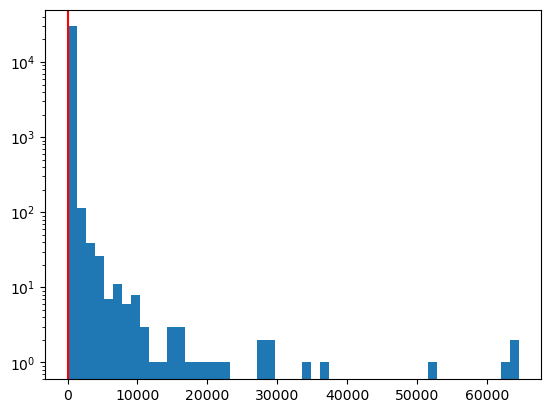

In [12]:
plt.hist(df['score'], bins = 50)
plt.axvline(df['score'].mean(), color = 'r')
plt.yscale('log');

## Feature Engineering Using Text Complexity Measurements

In [13]:
# Import libraries for data handling
import pandas as pd
import numpy as np

# Import libraries for text analysis
import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from textstat import textstat, automated_readability_index

# Import spaCy for syntactic complexity analysis
import spacy

# Import tqdm for progress bar (if needed for loops)
from tqdm.notebook import tqdm

# Download necessary NLTK models (if not previously downloaded)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/lgfolder/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
# Sample one random row and select only the 'Text' field
sample_text = df['Text'].sample(1).iloc[0]

# Print the sampled text
print(sample_text)

SNDL. My failed short term investment. [removed]


In [15]:
# Creating a boolean column for authors that messaged about GME

nlp = spacy.load("en_core_web_sm")

# Function to check for named entities 'GME', 'gme', 'GameStop', '$gme', '$GME'
def contains_gme_or_variants(text):
    doc = nlp(text)
    target_entities = {'GME', 'gme', 'GameStop', '$gme', '$GME'}
    return any(ent.text in target_entities for ent in doc.ents)

# Apply the function to each row in the 'Text' column and create a new boolean column
df['Contains_GME_Variants'] = df['Text'].apply(contains_gme_or_variants).astype(int)

In [16]:
# Creating a boolean column for authors that messaged about AMC
# Function to check for named entities 'AMC', 'amc','$amc', '$AMC'
def contains_amc_or_variants(text):
    doc = nlp(text)
    target_entities = {'AMC', 'amc','$amc', '$AMC'}
    return any(ent.text in target_entities for ent in doc.ents)

# Apply the function to each row in the 'Text' column and create a new boolean column
df['Contains_AMC_Variants'] = df['Text'].apply(contains_amc_or_variants).astype(int)

In [17]:
# Function to calculate readability score
def calc_readability(text):
    return textstat.flesch_kincaid_grade(text)

# Apply the function to the 'Text' column
df['Readability_Score'] = df['Text'].apply(calc_readability)

In [18]:
# Function to calculate vocabulary complexity
def calc_vocab_complexity(text):
    words = word_tokenize(text)
    freq_dist = FreqDist(words)
    return len(freq_dist) / float(len(words)) if len(words) > 0 else 0

# Apply the function to the 'Text' column
df['Vocab_Complexity'] = df['Text'].apply(calc_vocab_complexity)

In [19]:
# Function to count sentences and calculate average sentence length
def analyze_text(text):
    doc = nlp(text)
    num_sentences = len(list(doc.sents))
    total_words = sum(len(sentence) for sentence in doc.sents)
    avg_sentence_length = total_words / num_sentences if num_sentences > 0 else 0
    return num_sentences, avg_sentence_length

# Apply the function to each row in the DataFrame
df[['Num_Sentences', 'Avg_Sentence_Length']] = df['Text'].apply(lambda x: pd.Series(analyze_text(x)))

In [20]:
# Function to calculate Average Readability (ARI) score
def calc_ari(text):
    return automated_readability_index(text)

# Apply the function to the 'Text' column
df['ARI_Score'] = df['Text'].apply(calc_ari)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, l72klk to l8kggs
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   author                 30000 non-null  object 
 1   removed                30000 non-null  float64
 2   deleted                30000 non-null  float64
 3   is_self                30000 non-null  float64
 4   is_video               30000 non-null  float64
 5   link_flair_text        30000 non-null  object 
 6   upvote_ratio           30000 non-null  float64
 7   score                  30000 non-null  float64
 8   num_comments           30000 non-null  float64
 9   FolderName             30000 non-null  object 
 10  word_count_selftext    30000 non-null  float64
 11  word_count_title       30000 non-null  float64
 12  Text                   30000 non-null  object 
 13  Probab_not_rel         30000 non-null  float64
 14  Probab_yes_rel         30000 non-null  float64
 15  P

In [22]:
df = df.drop(['link_flair_text'], axis=1)

In [23]:
df.columns
df = df.drop(['Text'], axis=1)

In [24]:
df.drop_duplicates()
df = df.dropna()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, l72klk to l8kggs
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   author                 30000 non-null  object 
 1   removed                30000 non-null  float64
 2   deleted                30000 non-null  float64
 3   is_self                30000 non-null  float64
 4   is_video               30000 non-null  float64
 5   upvote_ratio           30000 non-null  float64
 6   score                  30000 non-null  float64
 7   num_comments           30000 non-null  float64
 8   FolderName             30000 non-null  object 
 9   word_count_selftext    30000 non-null  float64
 10  word_count_title       30000 non-null  float64
 11  Probab_not_rel         30000 non-null  float64
 12  Probab_yes_rel         30000 non-null  float64
 13  Post Relevance         30000 non-null  int64  
 14  Prob SELL              30000 non-null  float64
 15  P

Many features show a strong skew towards 0, and outliers will tend to skew distance based models. I do a log transform to make these distributions more normal.

In [26]:
# Grouping by 'author' and calculating the mean for each numeric column
df_agg_by_author = df.groupby('author').mean()

TypeError: Could not convert pennystocks to numeric

In [ ]:
df_agg_by_author.info()

In [ ]:
df = df.drop(['author'], axis=1)

In [ ]:
# Calculate the 99.5th percentile for 'score' and 'num_comments'
score_995_percentile = df_agg_by_author['score'].quantile(0.995)
num_comments_995_percentile = df_agg_by_author['num_comments'].quantile(0.995)

# Calculate the median values for 'score' and 'num_comments'
median_score = df_agg_by_author['score'].median()
median_num_comments = df_agg_by_author['num_comments'].median()

# Replace values above the 99.5th percentile with the median
df_agg_by_author.loc[df_agg_by_author['score'] > score_995_percentile, 'score'] = median_score
df_agg_by_author.loc[df_agg_by_author['num_comments'] > num_comments_995_percentile, 'num_comments'] = median_num_comments

## Clustering

In [ ]:
my_scaler = StandardScaler()
X = my_scaler.fit_transform(df_agg_by_author)
df_scaled = pd.DataFrame(X, columns = df_agg_by_author.columns)

In [ ]:
pca = PCA(n_components = 15)
pca_data = pca.fit_transform(df_scaled)
pca.explained_variance_ratio_.sum()

In [ ]:
#plt.figure(figsize = (8, 8))
#sns.pairplot(pd.DataFrame(pca_data))

t-SNE is a visualisation technique that ignores all information / variance in the dataset, and only preserves the relative positions of data points.

In [ ]:
# Runtime = 1m 23s seconds for 50000 sample 

sample = df_scaled.sample(frac = 0.1, random_state = 1)

tsne = TSNE(n_components = 3, random_state = 1, verbose = 1)
tsne_data = tsne.fit_transform(sample)

In [ ]:
sns.pairplot(pd.DataFrame(tsne_data))

Observation:
* Data points that were close together in XX(many) -dimensional space, are still close together in the new 3-dimensional space.
* There is one large blob, and one very small blob

## KMeans

In [ ]:
# Runtime is very long - 2m 30 sec for 5000 rows

inertias = []
silhouettes = []
k_range = np.arange(2, 15)

for k in k_range:
  print("In progress: K = ", k)
  my_kmeans = KMeans(n_clusters = k)
  my_kmeans.fit(df_scaled)
  labels = my_kmeans.predict(df_scaled)

  inertias.append(my_kmeans.inertia_)
  silhouettes.append(silhouette_score(df_scaled, labels))

Let's visualise our inertias in a Scree Plot

In [ ]:
plt.figure()
plt.plot(k_range, inertias, marker = 'o')
plt.xlabel("Nr clusters")
plt.ylabel("Inertia")
plt.show()

There is no obvious elbow point, after which adding more clusters has very little effect.
Let's use our silhouette scores as a second opinion.

In [ ]:
plt.figure()
plt.plot(k_range, silhouettes, marker='o')
plt.xlabel('Nr clusters')
plt.ylabel('Silhouette score')
plt.show()

Purely based on silhouette scores, where bigger is better, we would be tempted to try 100 clusters, but let's explore other options.

# KMeans with 4 clusters

In [ ]:
# Runtime 1m47s for 5000 sample

# cluster the data
kmeans = KMeans(n_clusters = 2)
labels = kmeans.fit_predict(df_scaled)

# add labels to original dataframe
df_kmeans = df_scaled.copy()
df_kmeans['labels'] = labels

# visualise with t-sne
sample = df_kmeans.sample(frac = 0.4, random_state = 1)
tsne = TSNE(n_components = 3, verbose=1, random_state = 1)
tsne_data = tsne.fit_transform(sample.drop('labels', axis = 1))

# rebuilt a dataframe
tsne_df = pd.DataFrame(tsne_data, columns = [f"tsne D {i}" for i in range(tsne_data.shape[1])])
tsne_df['labels'] = sample['labels'].values

# Pairplot
sns.pairplot(data = tsne_df, hue='labels')


In [ ]:
# Runtime 1m 45 sec for 5000 samples

# cluster the data
kmeans = KMeans(n_clusters = 20)
labels = kmeans.fit_predict(df_scaled)

# add labels to original dataframe
df_kmeans = df_scaled.copy()
df_kmeans['labels'] = labels

# visualise with t-sne
sample = df_kmeans.sample(frac = 0.4, random_state = 1)
tsne = TSNE(n_components = 3, verbose=1, random_state = 1)
tsne_data = tsne.fit_transform(sample.drop('labels', axis = 1))

# rebuilt a dataframe
tsne_df = pd.DataFrame(tsne_data, columns = [f"tsne D {i}" for i in range(tsne_data.shape[1])])
tsne_df['labels'] = sample['labels'].values

# Pairplot
sns.pairplot(data = tsne_df, hue='labels')

## DBSCAN

In [ ]:
# Runtime = 13 minutes for 50000 samples
silhouettes = []
num_clusters = []
epsilons = np.arange(1, 3, 0.1)

for eps in epsilons:
  model = DBSCAN(eps = eps, min_samples = 10)
  labels = model.fit_predict(df_scaled)

  n_clusters = len(np.unique(labels[labels != -1]))
  num_clusters.append(n_clusters)

  print(f"Eps: {eps}, N_clusters = {n_clusters}")

  silhouettes.append(silhouette_score(df_scaled, labels))

At very small values for epsilon, clusters can't reach far enough to the next data point, and many small clusters emerge.

At large values of epsilon, all data points are gobbled up by a single cluster

Values of epsilon to look at more closely are 2.1, resulting in 5 clusters, or 2.2 resulting in 2 clusters.

In [ ]:
dbscan_model = DBSCAN(eps=2.0, min_samples=10)
dbscan_y_labels = dbscan_model.fit_predict(df_scaled)


cc_df_dbscan = df_scaled.copy()
cc_df_dbscan['dbscan_labels'] = dbscan_y_labels


sample = cc_df_dbscan.sample(frac=0.4, random_state=1)

tsne = TSNE(n_components=3, verbose=2, random_state=1)

# We need to drop the labels so tSNE won't use them when computing distances
tsne_data = tsne.fit_transform(sample.drop('dbscan_labels', axis=1))

tsne_df = pd.DataFrame(tsne_data, columns=[f'tSNE D{i+1}' for i in range(tsne_data.shape[1])])
tsne_df['dbscan_labels'] = sample['dbscan_labels'].values.astype(str)
tsne_df

In [ ]:
sns.pairplot(tsne_df, hue="dbscan_labels", plot_kws={'alpha': 0.5})
plt.show()

DBSCAN seems to have assigned almost all data points to the same cluster. The data set doesn't contain sparse regions between denser regions and hence DBSCAN wasn't able delineate between clusters.

## Hierarchical clustering

In [ ]:
# Look at a dendogram for hierarchical
from scipy.cluster.hierarchy import linkage, dendrogram

# Use Ward
linkage_mat = linkage(df_scaled, 'ward')

# Look at scoring as well
plt.figure(figsize=(15,10))
dendrogram(linkage_mat)
plt.xticks([])
plt.show()

The dendrogram shows that two groups are easily separated, but more seems difficult

In [ ]:
# Try different clustering for agglomerative

ks = np.arange(2, 11)
silhouette_list = []

for k in ks:

    # Instantiate
    my_hclust = AgglomerativeClustering(n_clusters=k, linkage='ward')

    # Fit
    y_labels = my_hclust.fit_predict(df_scaled)

    # Calculate score
    silhouette = silhouette_score(df_scaled, y_labels)
    silhouette_list.append(silhouette)
    print(f"Computed Score for k={k}")

In [ ]:
plt.figure()
plt.plot(ks, silhouette_list, marker='o')
plt.xlabel('K - number of clusters')
plt.ylabel('silhouette score')
plt.xticks(ks)
plt.show()

## Comparing the Found Groups



In [ ]:
kmeans_final = KMeans(n_clusters = 16)

final_labels = kmeans_final.fit_predict(df_scaled)

In [ ]:
df_final = df_scaled.copy()
df_final['KMeans_cluster'] = final_labels

In [ ]:
df_final.head()

Let's start by exploring the means of each column for cluster 0 vs cluster 1

In [ ]:
relative_means = df_final.groupby('KMeans_cluster').mean()
relative_means.T

In [ ]:
# Assuming relative_means is already calculated as shown in the previous message
# Calculating the variance of the relative means
variance_relative_means = relative_means.var(axis=0)

# Sorting the variance in descending order and selecting the top 5 fields
top_5_variance_fields = variance_relative_means.sort_values(ascending=False).head(10)
top_5_variance_fields

In [ ]:
sns.boxplot(data = df_final, x = 'KMeans_cluster', y='Prob BUY');

In [ ]:
melted_means = relative_means.reset_index().melt(id_vars='KMeans_cluster')

In [ ]:
# Calculating the absolute difference between the means of the two clusters
melted_means['abs_diff'] = melted_means.groupby('variable')['value'].transform(lambda x: abs(x.diff()).fillna(0))

# Sorting by absolute difference and selecting top variables
top_features = melted_means.sort_values('abs_diff', ascending=False).drop_duplicates('variable').head(10)

# Plotting the top distinguishing features
sns.barplot(data=top_features, x='value', y='variable', hue='KMeans_cluster')


Observations:


### Characteristics (based on hierarchical clustering)

In [ ]:
final_hier = AgglomerativeClustering(n_clusters = 5, linkage = 'ward')
hier_labels = final_hier.fit_predict(df_scaled)

In [ ]:
df_final['hierarchical_clusters'] = hier_labels

In [ ]:
df_final.head().T

In [ ]:
pd.crosstab(df_final['KMeans_cluster'], df_final['hierarchical_clusters'])

In [ ]:
# Assuming relative_means is already calculated as shown in the previous message
# Calculating the variance of the relative means
variance_relative_means = relative_means.var(axis=0)

# Sorting the variance in descending order and selecting the top 5 fields
top_5_variance_fields = variance_relative_means.sort_values(ascending=False).head(5)
top_5_variance_fields

In [ ]:
relative_means = df_final.groupby('hierarchical_clusters').mean()

melted_means = relative_means.reset_index().melt(id_vars='hierarchical_clusters')
sns.barplot(data = melted_means, x= 'value', y= 'variable', hue = 'hierarchical_clusters');